In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import joblib
import utm
import tensorflow as tf
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [38]:
### Enter Sequence Length below that should be used for Validation check

In [39]:
total_seq_len = 300
input_len = 100

In [40]:
#unseen validation data

data = pd.read_csv("traj_data_v2_300_seq_train.csv")
#data = pd.read_csv("traj_data_v2_100_seq.csv")

data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,149850.000000,151.187826,-33.894480,0.000003,0.000003
std,86602.684716,86602.641415,0.002236,0.001248,0.000135,0.000065
min,0.000000,0.000000,151.184833,-33.895620,-0.000384,-0.000261
25%,74999.750000,74925.000000,151.186473,-33.895169,-0.000068,-0.000037
50%,149999.500000,149850.000000,151.187480,-33.894783,0.000000,0.000000
75%,224999.250000,224775.000000,151.188458,-33.894342,0.000078,0.000044
max,299999.000000,299700.000000,151.194604,-33.889197,0.000397,0.000259


In [41]:
global scaler
scaler = joblib.load("scaler_300_seq.save")

c:\users\dnybe\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [42]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    #scaler = joblib.load("scaler_100_seq.save")
    #data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    data[['X_REL', 'Y_REL']] = scaler.transform(data[['X_REL', 'Y_REL']])
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    outputs = []
    indexes = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          seq_inner = []
          indexes_inner = []
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
            indexes_inner.append(ped)
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
          indexes.append([indexes_inner])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [43]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = total_seq_len, input_len = 100)

In [47]:
"""Reshaping data for input into LSTM"""
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)

test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)

In [48]:
"""Load Pretrained LSTM Model for correct sequence length"""
model = keras.models.load_model('LSTM_300.h5')
#model = keras.models.load_model('newencoder_decoder.h5')

In [49]:
input_len = 100
target_len = 198
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        data = data_source_inputs[i,:,:]
        res = model.predict(data_source_inputs[i:i+1])
        ground_truths.append(data_source_targets[i].squeeze().tolist())
        predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
        inputs.append(data.squeeze().tolist())
            
    return inputs, ground_truths, predictions

In [50]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [53]:
def get_real_coords(target_list, preds_list, inputs_list, test_indx):
    """
    Get the real word coordinates of trajectories starting from bins
    All input parameteres must be lists of lists and be of the same length
    Returns a dataframe with vehicle ID and all of its real word coordinates in Lat/Long
    """
    x_cords_real = []
    y_cords_real = []
    x_cords_pred = []
    y_cords_pred = []
    vehicle_ids = []

    for ind in range(len(test_indx)):

      for inp in test_indx[ind]:
        for inp_nr in inp[:-1]:
          vehicle_ids.append(inp_nr)

      for inp in inputs_list[ind]:
        x = inp % 100
        y = inp / 100 
        x_cords_real.append(x)
        y_cords_real.append(y)

        x_cords_pred.append(x)
        y_cords_pred.append(y)
        
      for inp in target_list[ind]:
        x = inp % 100
        y = inp / 100 
        x_cords_real.append(x)
        y_cords_real.append(y)

      for inp in preds_list[ind]:
        x = inp % 100
        y = inp / 100 
        x_cords_pred.append(x)
        y_cords_pred.append(y)

    dict_pd = {'Vehicle_ID': vehicle_ids, 'X_REAL': x_cords_real, 'Y_REAL': y_cords_real, 'X_PRED': x_cords_pred, 'Y_PRED': y_cords_pred} 
    output_df = pd.DataFrame(dict_pd)
    output_df[['X_REAL', 'Y_REAL']] = scaler.inverse_transform(output_df[['X_REAL', 'Y_REAL']])
    output_df[['X_PRED', 'Y_PRED']] = scaler.inverse_transform(output_df[['X_PRED', 'Y_PRED']])
    
    unique_vehicle_ids = output_df['Vehicle_ID'].unique()
    for id in unique_vehicle_ids:
      subset = data.loc[data['Vehicle_ID'] == id, ['X', 'Y']].head(1)
      x_origin, y_origin = subset.X.item(), subset.Y.item()
      output_df.loc[output_df['Vehicle_ID'] == id, ['X_REAL', 'X_PRED']] = output_df.loc[output_df['Vehicle_ID'] == id, ['X_REAL', 'X_PRED']] + x_origin
      output_df.loc[output_df['Vehicle_ID'] == id, ['Y_REAL', 'Y_PRED']] = output_df.loc[output_df['Vehicle_ID'] == id, ['Y_REAL', 'Y_PRED']] + y_origin
    return output_df

def calc_meter_dist(xt, yt, xp, yp):
    """
    Converts real_world Latitude Longitude coordinates into UTM coordinates
    to get a difference in meters between prediction and target values
    """
    tar_utm = utm.from_latlon(yt, xt)
    pred_utm = utm.from_latlon(yp, xp)

    dist_x = tar_utm[0] - pred_utm[0]
    dist_y = tar_utm[1] - pred_utm[1]
    
    return np.sqrt((dist_x ** 2) + (dist_y ** 2))

def calculate_performance_metrics(df):
    """
    Calculates Average Displacement Error (ADE) and Final Displacement Error (FDE)
    for a given data frame containing the features:
        X_REAL, Y_REAL, X_PRED, Y_PRED
    """
    unique_vehicle_ids = df['Vehicle_ID'].unique()
    res = []
    for id in unique_vehicle_ids:
        res.append(df[df['Vehicle_ID'] == id][input_len:])
    res_df = pd.concat(res)
        
    res_df['DIST'] = res_df.apply(lambda row: calc_meter_dist(row['X_REAL'],row['Y_REAL'],row['X_PRED'],row['Y_PRED']),axis=1) 
    ADE = res_df['DIST'].mean()
    
    FDE = 0
    counter = 0
    for id in unique_vehicle_ids:
        x = res_df[res_df['Vehicle_ID'] == id]
        FDE += x.tail(1).DIST.values
        counter += 1
    FDE = float(FDE/counter)
        
    print("Average Displacement Error (meters): ", ADE)
    print("Average Final Displacement Error: (meters)", FDE)
    return df

In [54]:
coords = get_real_coords(target_list, preds_list, inputs_list, test_indx)
d = calculate_performance_metrics(coords)

Average Displacement Error (meters):  2.921754825622762
Average Final Displacement Error: (meters) 4.9482666276451805


In [59]:
def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):

  for i in range(1, 100, 1):
    print(i)
    plt.figure(figsize=(6,6))
    inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs:
      x = inp % 100
      y = inp / 100 
      xy_inputs.append([x, y])
    
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='black')
    plt.scatter(x_pred,y_pred, color='r')

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()

1


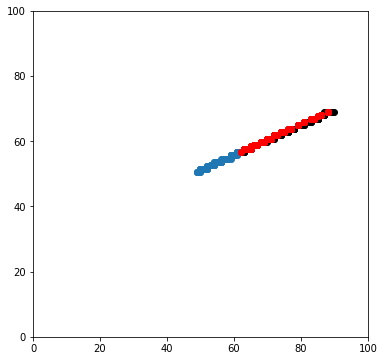

2


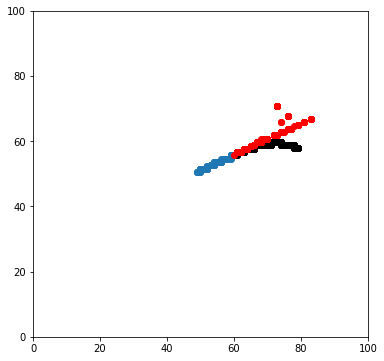

3


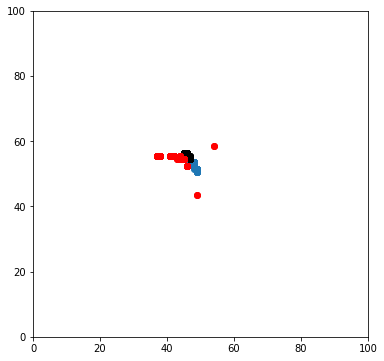

4


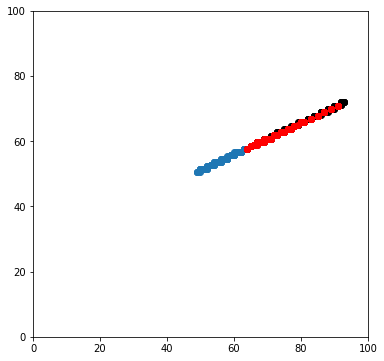

5


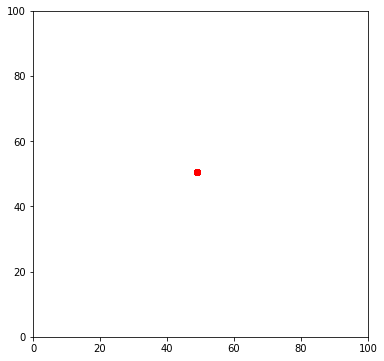

6


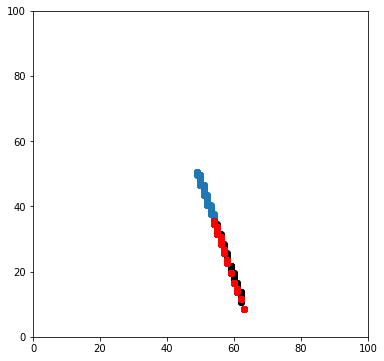

7


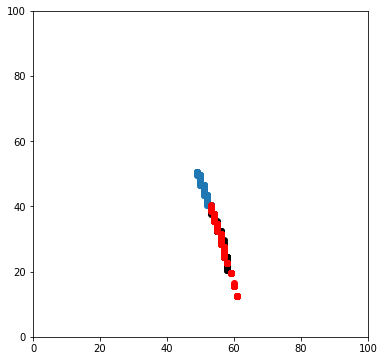

8


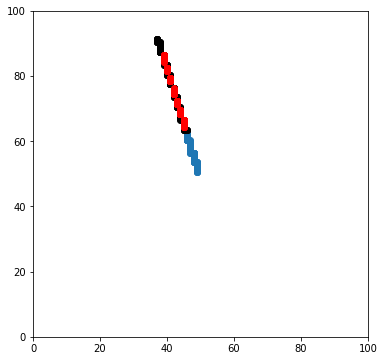

9


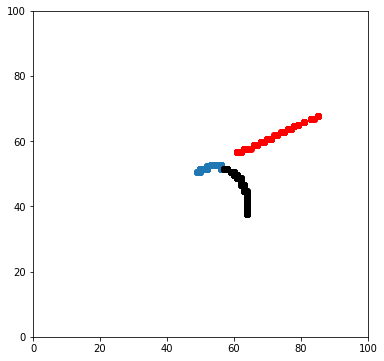

10


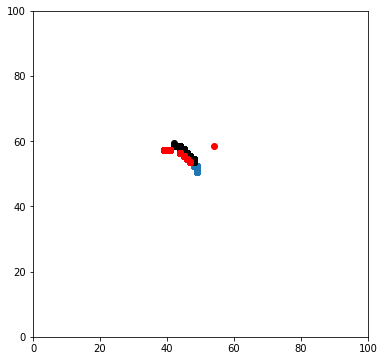

11


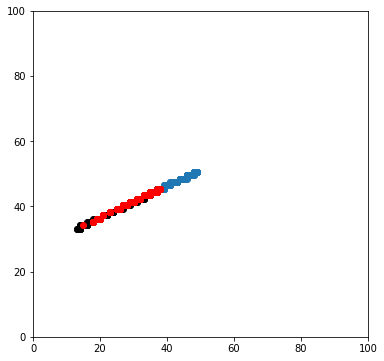

12


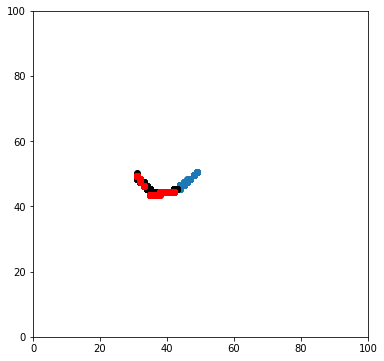

13


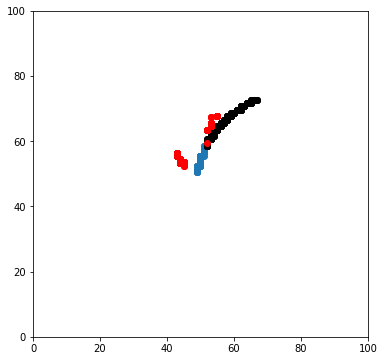

14


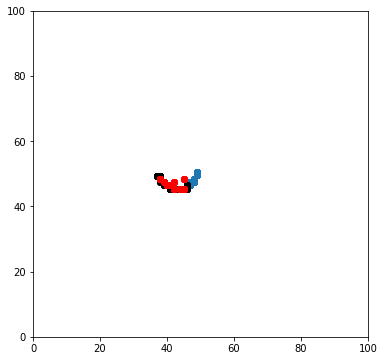

15


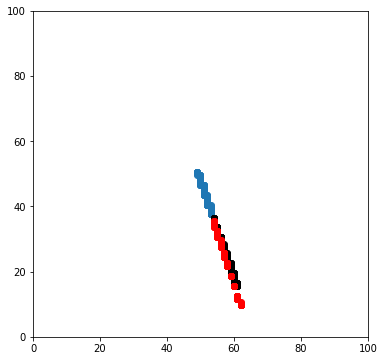

16


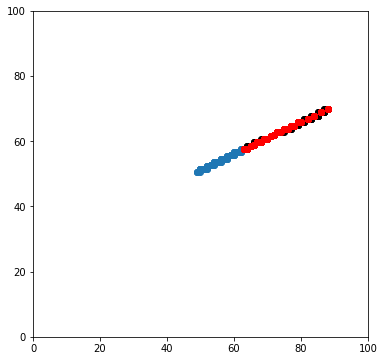

17


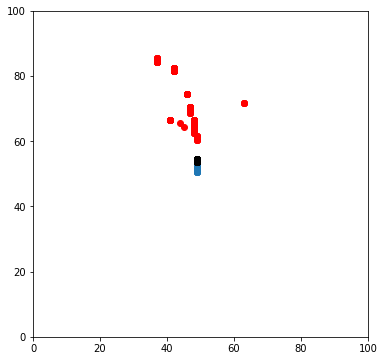

18


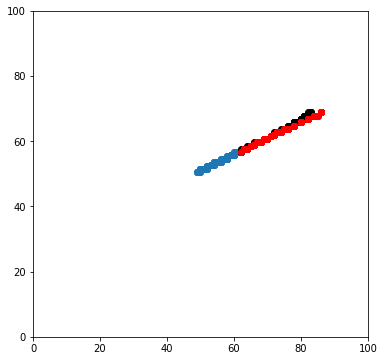

19


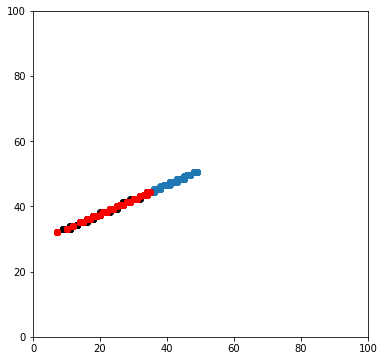

20


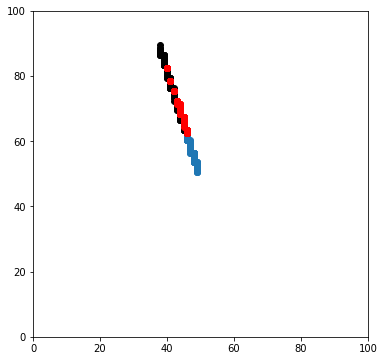

21


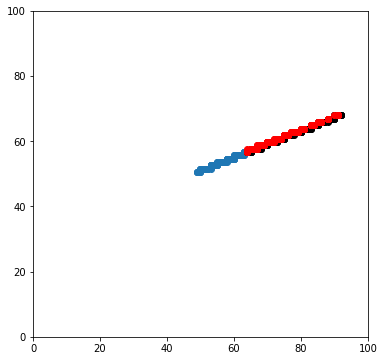

22


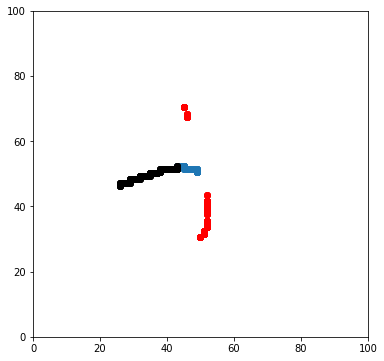

23


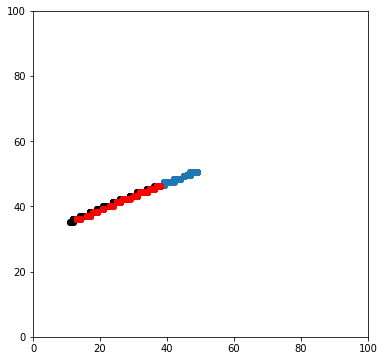

24


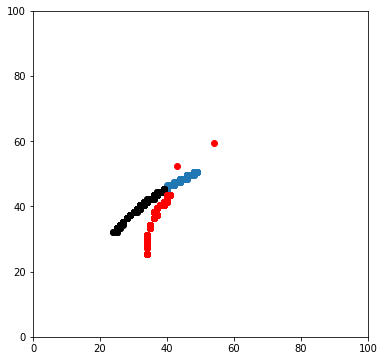

25


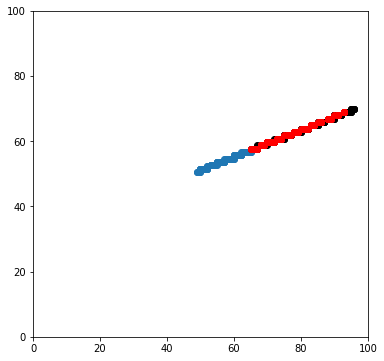

26


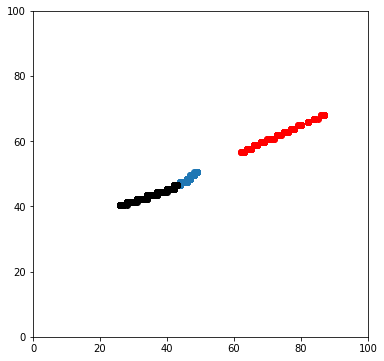

27


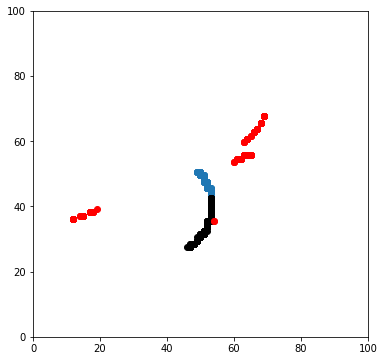

28


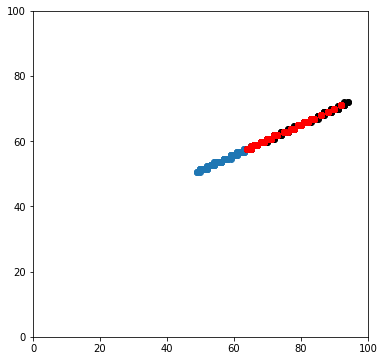

29


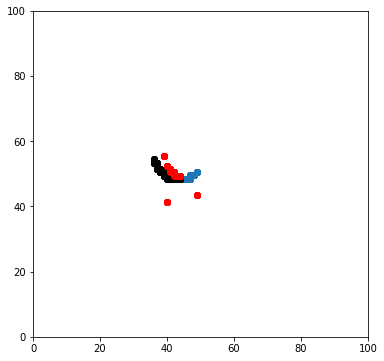

30


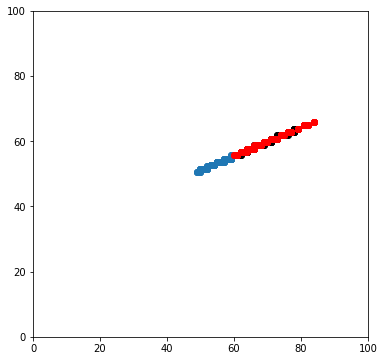

31


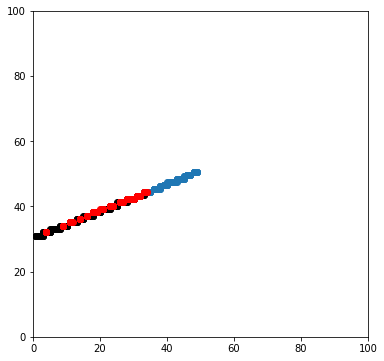

32


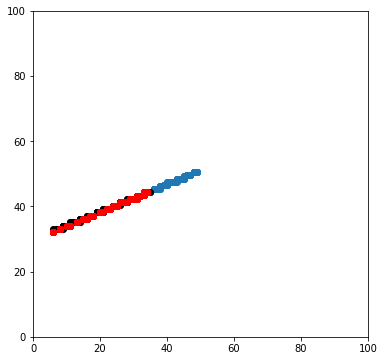

33


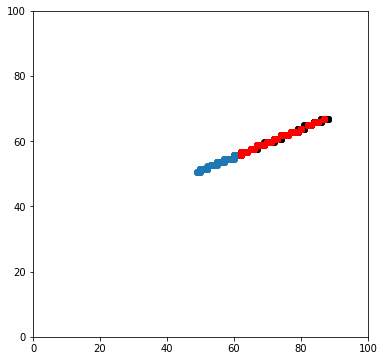

34


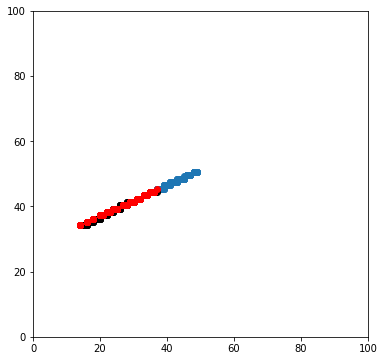

35


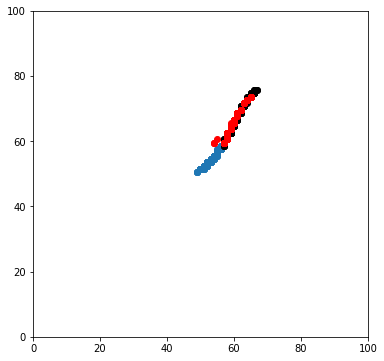

36


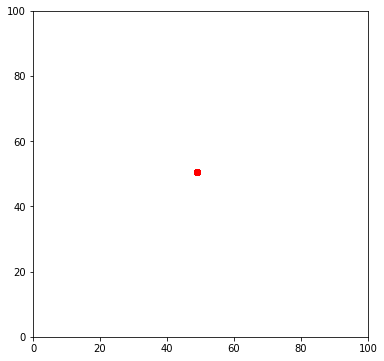

37


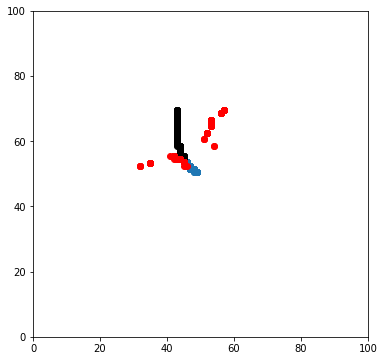

38


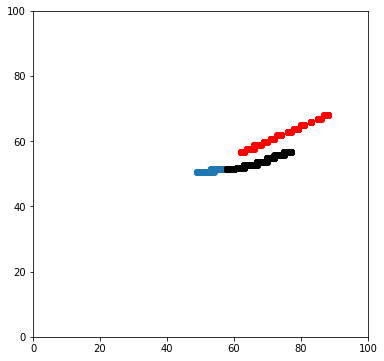

39


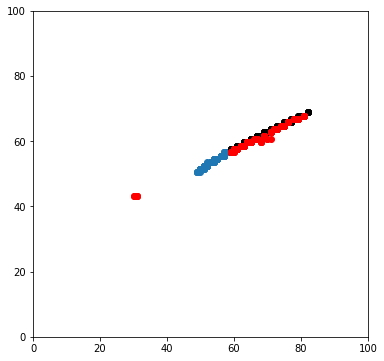

40


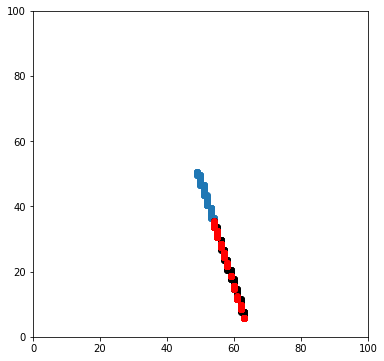

41


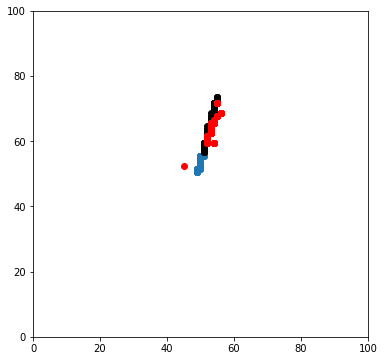

42


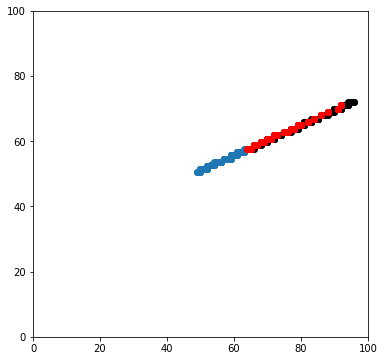

43


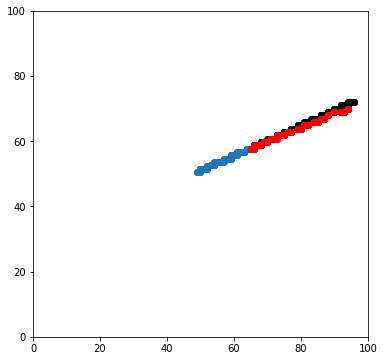

44


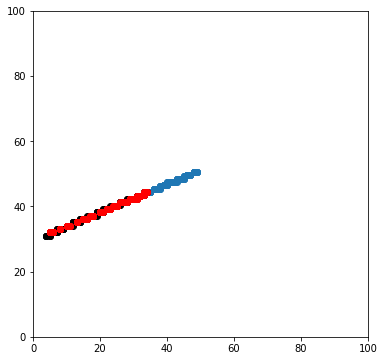

45


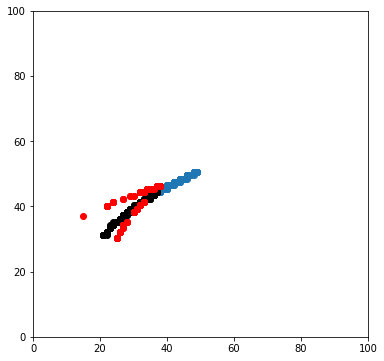

46


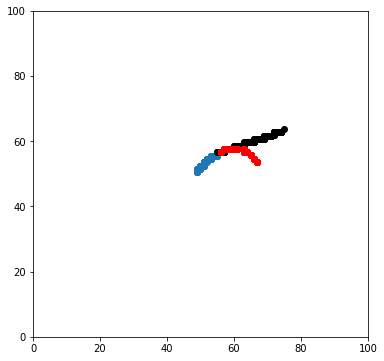

47


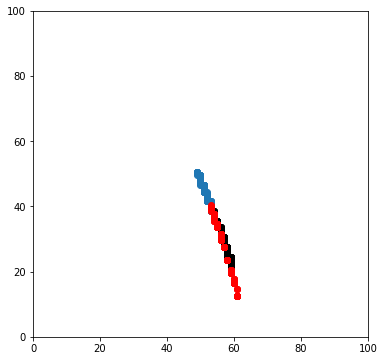

48


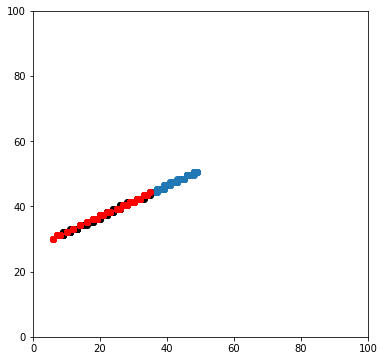

49


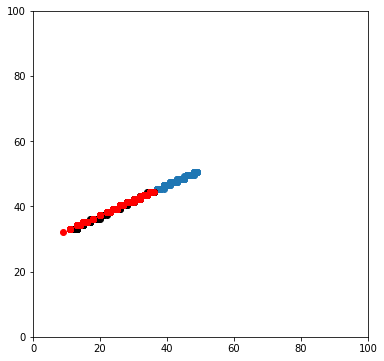

50


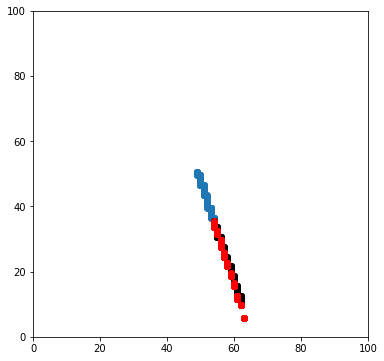

51


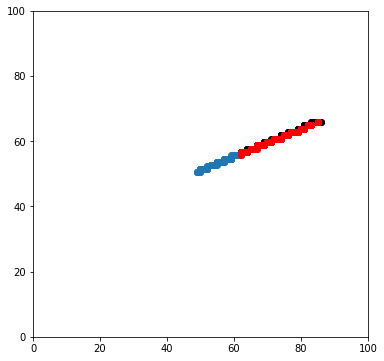

52


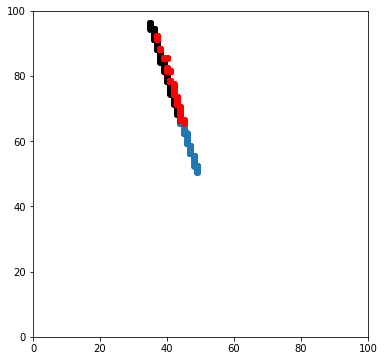

53


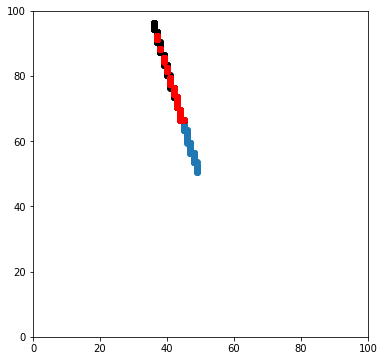

54


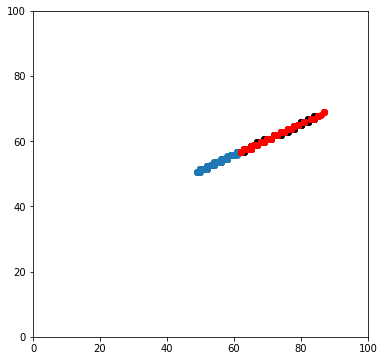

55


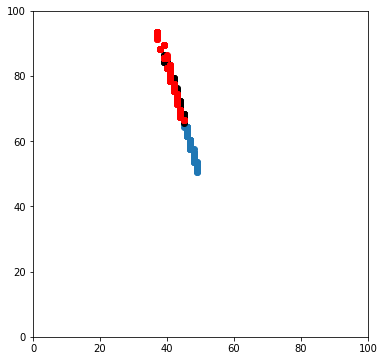

56


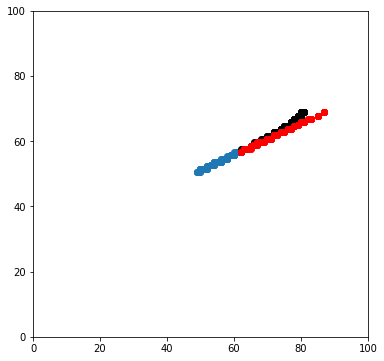

57


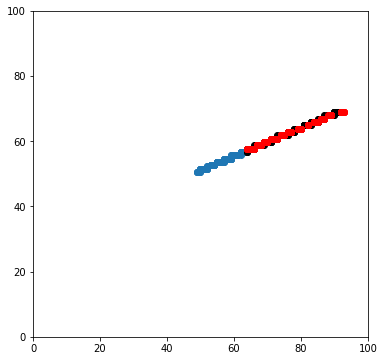

58


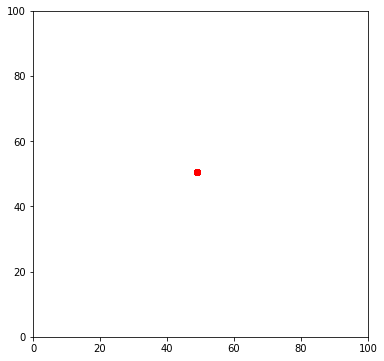

59


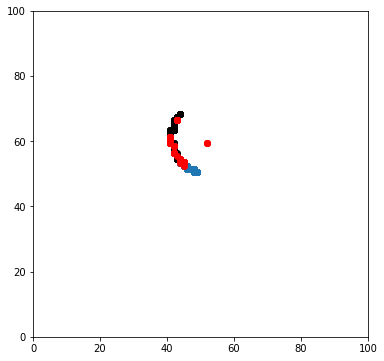

60


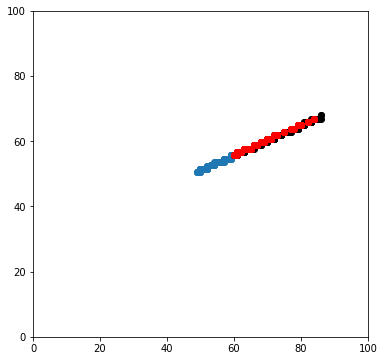

61


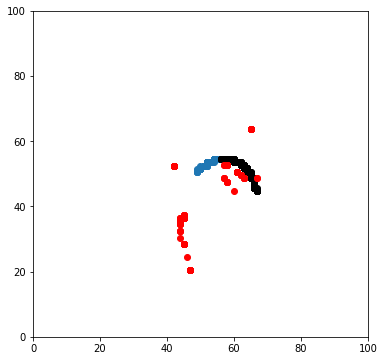

62


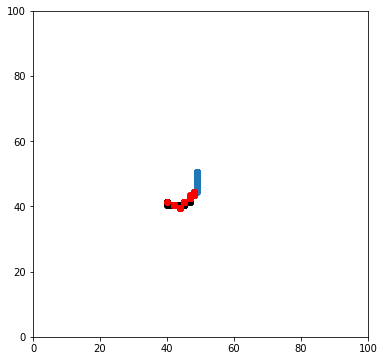

63


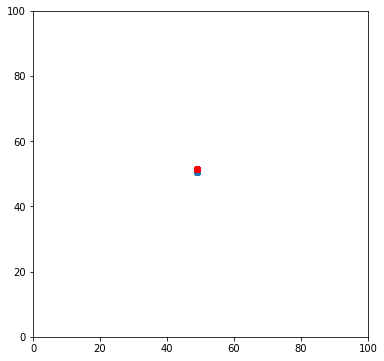

64


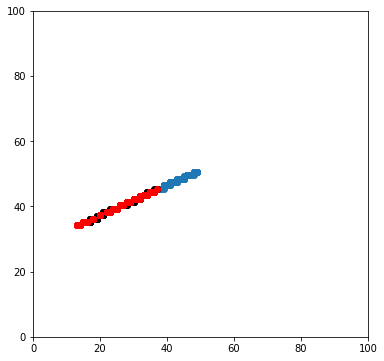

65


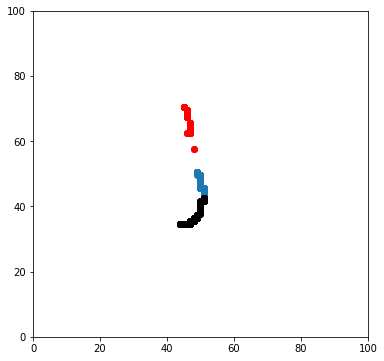

66


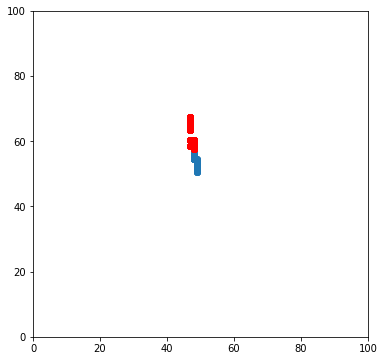

67


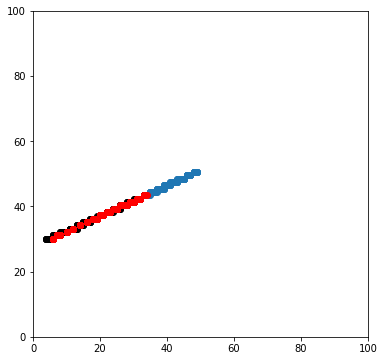

68


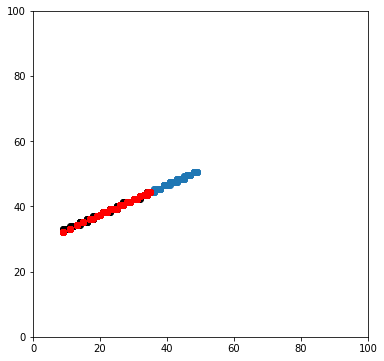

69


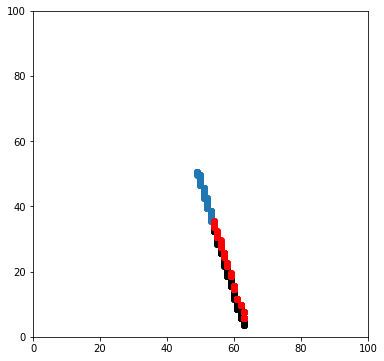

70


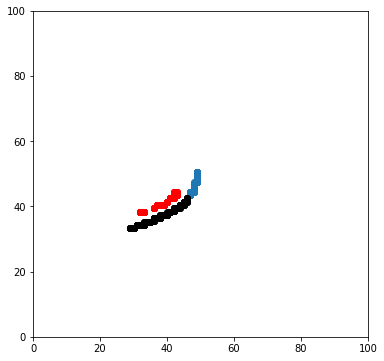

71


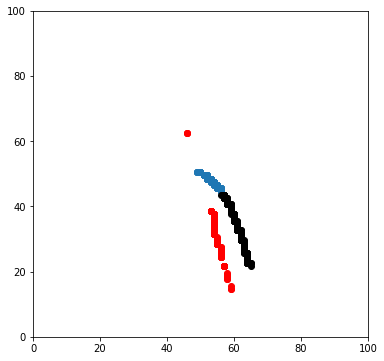

72


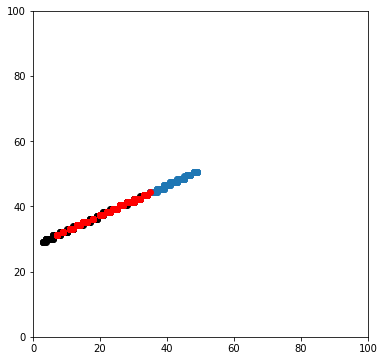

73


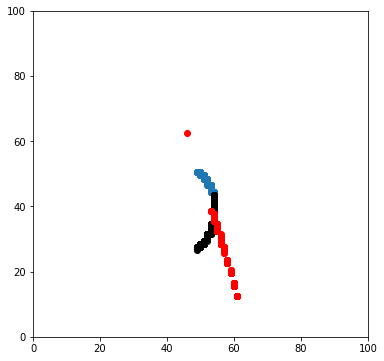

74


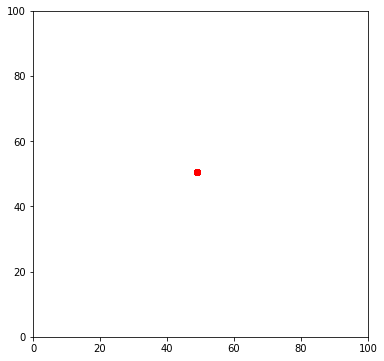

75


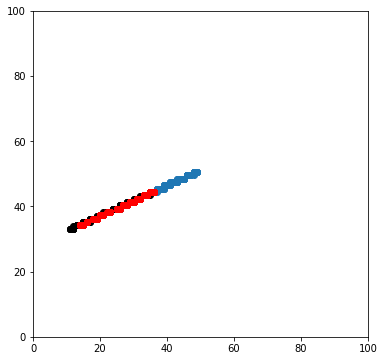

76


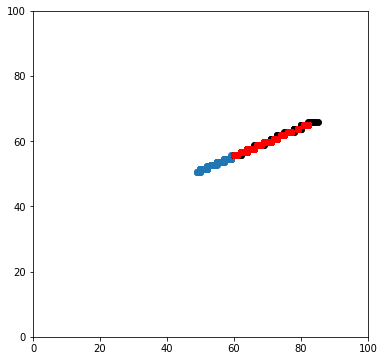

77


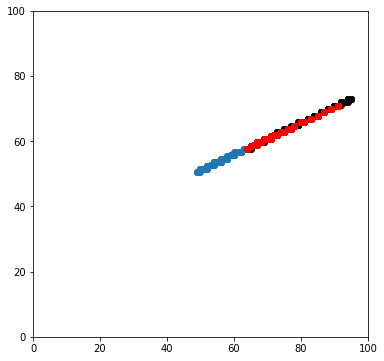

78


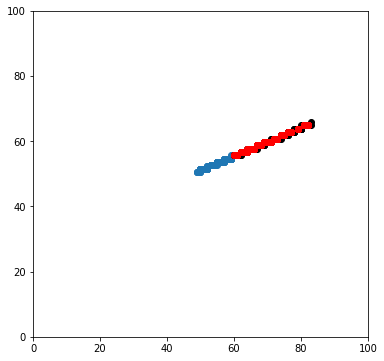

79


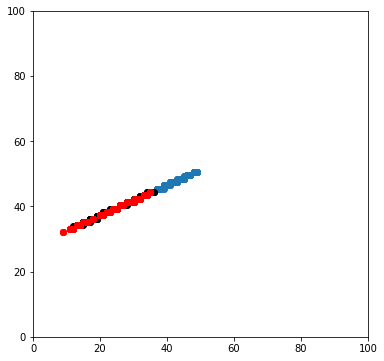

80


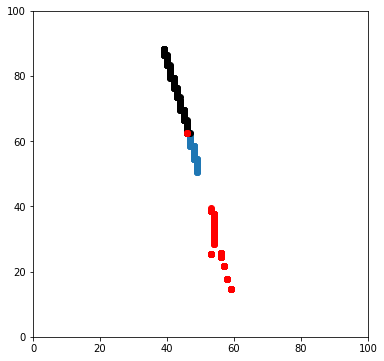

81


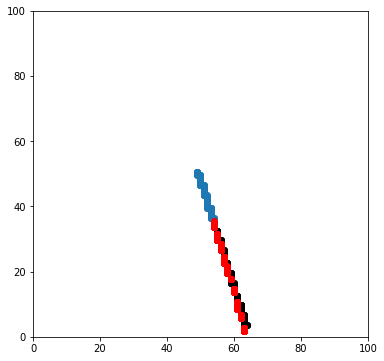

82


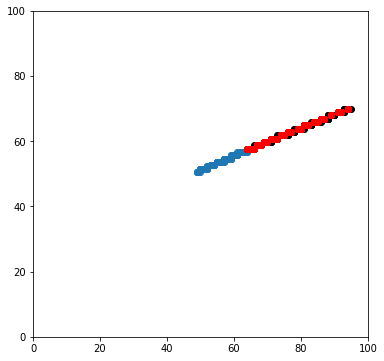

83


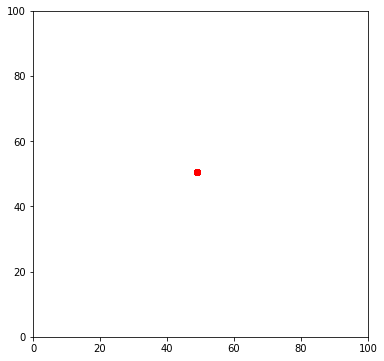

84


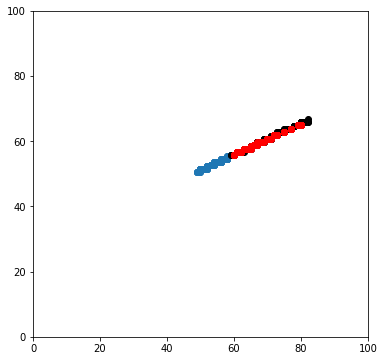

85


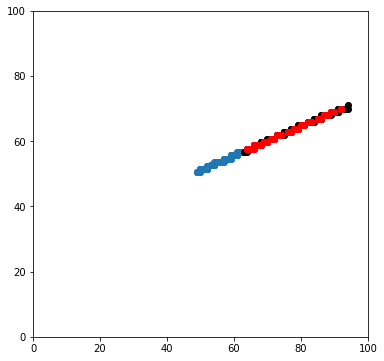

86


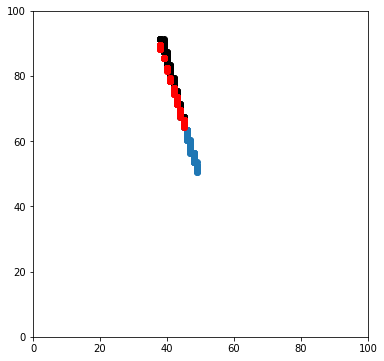

87


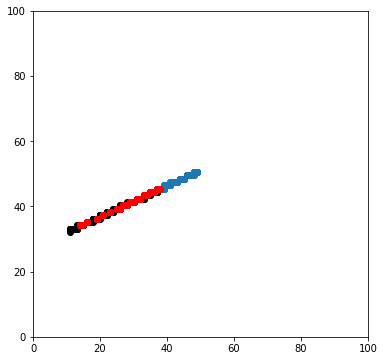

88


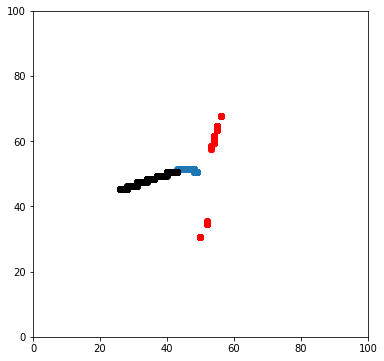

89


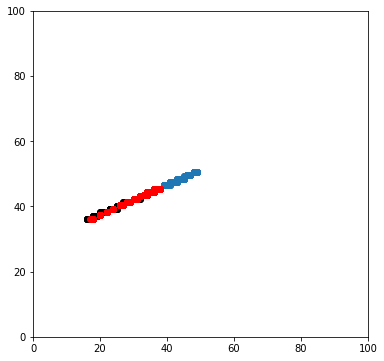

90


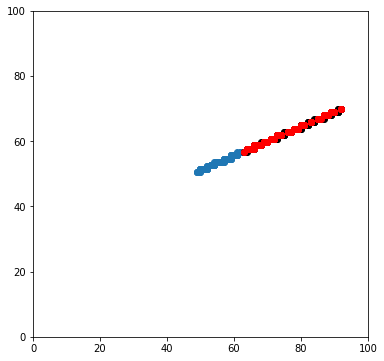

91


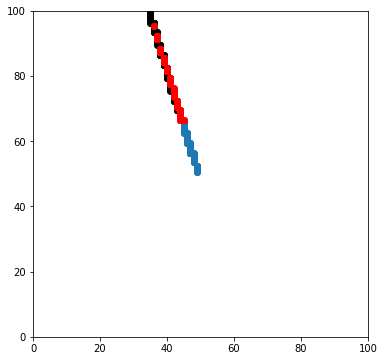

92


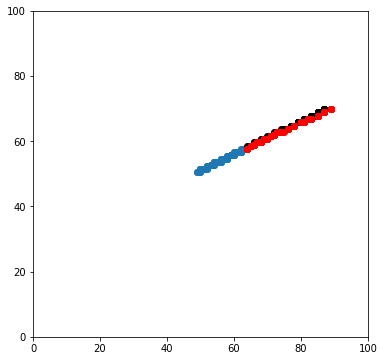

93


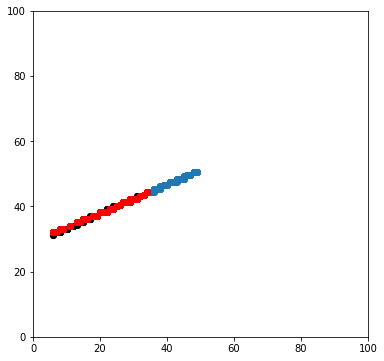

94


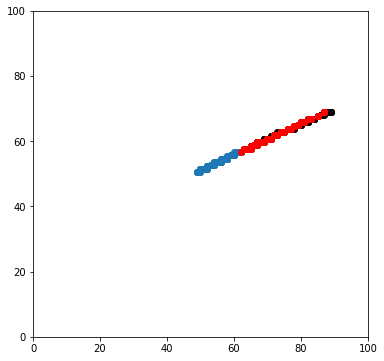

95


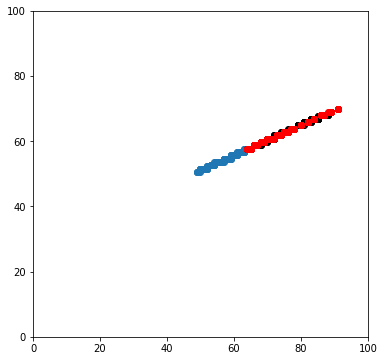

96


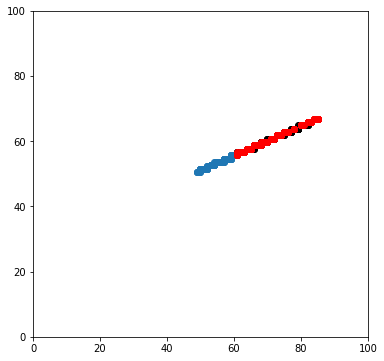

97


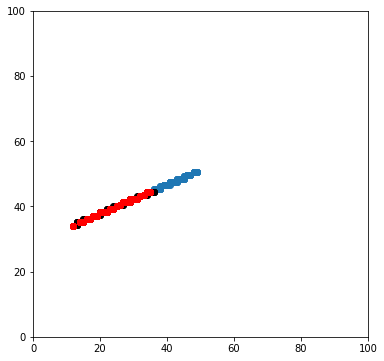

98


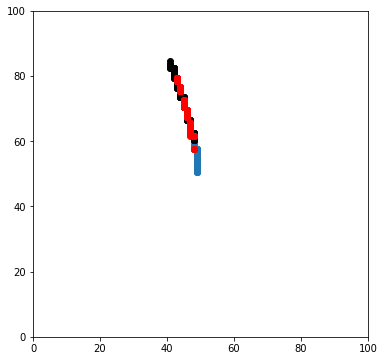

99


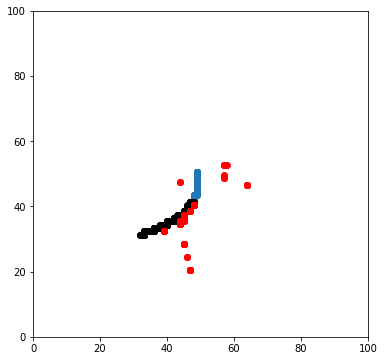

In [60]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [ ]:
#interesting? 18, 34, 106, 110, 264, 848, 998 #number 59 for 300s, 56